In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np

One of the problems with online learning is catastrophic forgetting.  In Dhireesha Kudithipudi's keynote talk at ICONS 2023, she gave an overview of different methods of dealing with this problem, including various forms of metaplasicity.  The basic idea of metaplasticity is to modulate the learning rate at a per-neuron level, based on the neuron's past history.

This struck me as something that could be easily added to standard delta rule and could be interesting to explore.

Here is a simple nengo learning rule that has a separate input `meta` which is a per-neuron scaling parameter.  If we set it to 1, then it is the same as delta rule / PES.  

In [2]:
class Learner(nengo.processes.Process):
    def __init__(self, size_in, size_out, tau_learn):
        self.size_in = size_in
        self.size_out = size_out
        self.tau_learn = tau_learn   # convergence time of the learning process
        super().__init__(default_size_in=size_in*2+size_out,
                         default_size_out=size_out)
        
    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        w = np.zeros((self.size_out, self.size_in))
        learn_scale = 1-np.exp(-dt/self.tau_learn)
        
        def step_learn(t, x, w=w, learn_scale=learn_scale):
            pre, meta, error = x[:self.size_in], x[self.size_in:self.size_in*2],x[self.size_in*2:]
            
            # compute the learning rate that will give the desired convergence time
            lr = np.sum(pre*pre*meta)
            if lr != 0:
                lr = 1.0 / lr
            lr = learn_scale * lr
            
            w -= lr * np.outer(error, pre*meta)            
            
            return w @ pre
        return step_learn


One additional complication being added here is that I'm not specifying a learning rate.  Instead, I'm specifying a `tau_learn`: that is, a learning *time*.  Given a fixed input and a fixed target value, the output should approach the target value exponentially, and the time constant should be `tau_learn`.  This is a nice generic way of setting a learning rate that is not dependent on the number of neurons or the pattern of activity in the population.  Indeed, it can be thought of as a generalization of the standard nengo trick of scaling the learning rate by the number of neurons (given twice as many neurons, you generally need half the learning rate to get the same convergence time).

Note: I could have just left this with a normal learning rate parameter, but then we'd have to change and adjust that learning rate all the time as we make the various adjustments to the learning rule below.  So this added complexity simplifies the exploration.

In any case, let's try out the learning rule with a constant input and target value and see if it works.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

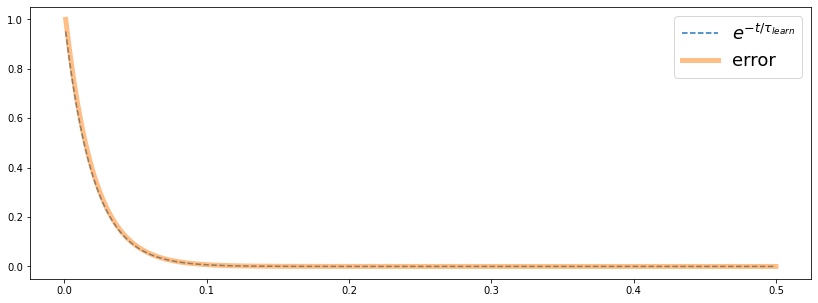

In [3]:
N = 100

model = nengo.Network()
with model:
    model.config[nengo.Connection].synapse=None
    stim = nengo.Node(1)
    target = nengo.Node(-1)
    output = nengo.Node(None, size_in=1)
    ens = nengo.Ensemble(n_neurons=N, dimensions=1, neuron_type=nengo.LIFRate())
    nengo.Connection(stim, ens)
    
    learn = nengo.Node(Learner(size_in=ens.n_neurons, size_out=target.size_out,
                               tau_learn=0.02))
    error = nengo.Node(None, size_in=1)
    nengo.Connection(ens.neurons, learn[:ens.n_neurons])
    # feed i
    nengo.Connection(nengo.Node([1]*ens.n_neurons), learn[ens.n_neurons:ens.n_neurons*2])
    nengo.Connection(ens.neurons, learn[ens.n_neurons:ens.n_neurons*2])
    nengo.Connection(learn, output)
    nengo.Connection(output, error)
    nengo.Connection(target, error, transform=-1)
    nengo.Connection(error, learn[-target.size_out:], synapse=0)
    
    p_error = nengo.Probe(error)

sim = nengo.Simulator(model)
with sim:
    sim.run(0.5)
    
plt.figure(figsize=(14,5))
plt.plot(sim.trange(), np.exp(-sim.trange()/learn.output.tau_learn), ls='--', label=r'$e^{-t/ \tau_{learn}}$')
plt.plot(sim.trange(), sim.data[p_error], lw=5, alpha=0.5, label='error')
plt.legend(fontsize=18)
plt.show()
    
    

It converges to the correct answer, and does so at the desired rate.

Now, this is just normal delta rule still, so if we try training it on three different data points, it will probably have the standard catastrophic forgetting problem.  Let's generate some training data and try that.  We'll just generate a few D-dimensional vectors for inputs and a few more D-dimensional vectors for outputs.  We'll present each one for 0.1 seconds and we'll set tau_learn to 0.02, so we're pretty sure it'll be converged by the end of the 0.1 seconds.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

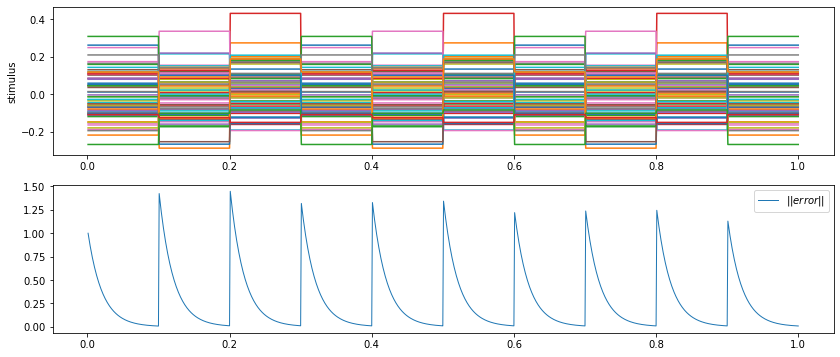

In [4]:
D = 64
N = 500
n_pairs = 3

import nengo_spa as spa
vocab = spa.Vocabulary(D, strict=False)
pairs = [(vocab.parse(f'A{i}'), vocab.parse(f'B{i}')) for i in range(n_pairs)]

t_present = 0.1


model = nengo.Network()
with model:
    model.config[nengo.Connection].synapse=None
    stim = nengo.Node(nengo.processes.PresentInput([p[0].v for p in pairs], presentation_time=t_present))
    target = nengo.Node(nengo.processes.PresentInput([p[1].v for p in pairs], presentation_time=t_present))
    output = nengo.Node(None, size_in=D)
    ens = nengo.Ensemble(n_neurons=N, dimensions=D, neuron_type=nengo.LIFRate())
    nengo.Connection(stim, ens)
    
    learn = nengo.Node(Learner(size_in=ens.n_neurons, size_out=target.size_out,
                               tau_learn=0.02))
    error = nengo.Node(None, size_in=D)
    nengo.Connection(ens.neurons, learn[:ens.n_neurons])
    nengo.Connection(nengo.Node(1), learn[ens.n_neurons:ens.n_neurons*2], transform=np.ones((ens.n_neurons,1)))
    nengo.Connection(learn, output)
    nengo.Connection(output, error)
    nengo.Connection(target, error, transform=-1)
    nengo.Connection(error, learn[-target.size_out:], synapse=0)
    
    p_error = nengo.Probe(error)
    p_stim = nengo.Probe(stim)

sim = nengo.Simulator(model)
with sim:
    sim.run(1)
    
plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.ylabel('stimulus')
plt.subplot(2,1,2)
plt.plot(sim.trange(), np.linalg.norm(sim.data[p_error], axis=1), lw=1, label='$||error||$')
plt.legend()
plt.show()

This is classic catastrophic forgetting.  It learns each case fine, but then when it learns the next case, all of that learning undoes the learning of the first case, so it has to learn it again.

One way we've tried dealing with this problem in the past is by changing the neural representation so that it is extremely sparse.  With normal delta learning rule, any neurons that aren't active won't have their weights changed, so if we're only changing a few weights, this should have less of a chance of breaking things we've learned before.

Let's try that here by setting our intercepts so that the neurons are 90% sparse (i.e. a neuron is only active for 10% of the possible inputs)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

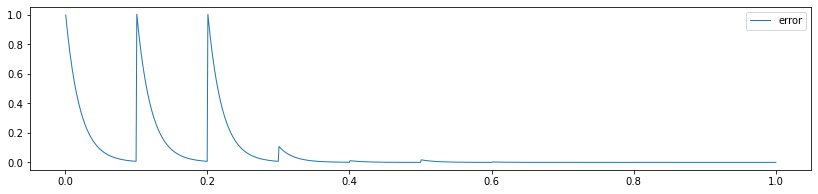

In [5]:
import scipy.special
def sparsity_to_x_intercept(d, p):
    sign = -1
    if p > 0.5:
        p = 1.0 - p
        sign = 1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))

model = nengo.Network()
with model:
    model.config[nengo.Connection].synapse=None
    stim = nengo.Node(nengo.processes.PresentInput([p[0].v for p in pairs], presentation_time=t_present))
    target = nengo.Node(nengo.processes.PresentInput([p[1].v for p in pairs], presentation_time=t_present))
    output = nengo.Node(None, size_in=D)
    ens = nengo.Ensemble(n_neurons=N, dimensions=D, neuron_type=nengo.LIFRate(),
                         # set the intercepts so the ensemble is 90% sparse
                         intercepts=nengo.dists.Choice([sparsity_to_x_intercept(D, 0.9)]))
    nengo.Connection(stim, ens)
    
    learn = nengo.Node(Learner(size_in=ens.n_neurons, size_out=target.size_out,
                               tau_learn=0.02))
    error = nengo.Node(None, size_in=D)
    nengo.Connection(ens.neurons, learn[:ens.n_neurons])
    nengo.Connection(nengo.Node(1), learn[ens.n_neurons:ens.n_neurons*2], transform=np.ones((ens.n_neurons,1)))
    nengo.Connection(learn, output)
    nengo.Connection(output, error)
    nengo.Connection(target, error, transform=-1)
    nengo.Connection(error, learn[-target.size_out:], synapse=0)
    
    p_error = nengo.Probe(error)

sim = nengo.Simulator(model)
with sim:
    sim.run(1)
    
plt.figure(figsize=(14,3))
plt.plot(sim.trange(), np.linalg.norm(sim.data[p_error], axis=1), lw=1, label='error')
plt.legend()
plt.show()

Success!  This is the neural sparsity approach to dealing with catastrophic forgetting.  There is minimal interference, in that learning one new item doesn't affect the other items it has learned (much).  However, this does run into the problem that something has to carefully set up the neurons so that they have that property.  It'd be nice to have a similar result, but normal neural activity.

So now let's go back to the original version and try it with a metaplasticity approach.  

For my first attempt, let's scale the learning rate of each neuron *inversely proportionally to how active the neuron has been in the past*.  That is, if a neuron hasn't been used very much in the past, then I want to adjust its weight a lot more, and so its learning rate should be higher.  If a neuron has been used a lot, then we probably shouldn't change its weight much.

To compute how active the neuron has been in the past, let's just use a long-time-constant low-pass filter on the neural activity.  Since the activity could be zero, instead of $1/x$ for the inverse proportionality, let's do $1/(x+1)$.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

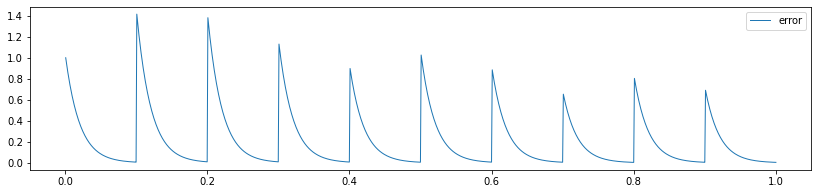

In [6]:
model = nengo.Network()
with model:
    model.config[nengo.Connection].synapse=None
    stim = nengo.Node(nengo.processes.PresentInput([p[0].v for p in pairs], presentation_time=t_present))
    target = nengo.Node(nengo.processes.PresentInput([p[1].v for p in pairs], presentation_time=t_present))
    output = nengo.Node(None, size_in=D)
    ens = nengo.Ensemble(n_neurons=N, dimensions=D, neuron_type=nengo.LIFRate(),
                        )
    nengo.Connection(stim, ens)
    
    learn = nengo.Node(Learner(size_in=ens.n_neurons, size_out=target.size_out,
                               tau_learn=0.02))
    error = nengo.Node(None, size_in=D)
    nengo.Connection(ens.neurons, learn[:ens.n_neurons])
    
    meta = nengo.Node(lambda t, x:1/(x+1), size_in=N, size_out=N)
    nengo.Connection(ens.neurons, meta, synapse=0.1)
    nengo.Connection(meta, learn[ens.n_neurons:ens.n_neurons*2])
    
    nengo.Connection(learn, output)
    nengo.Connection(output, error)
    nengo.Connection(target, error, transform=-1)
    nengo.Connection(error, learn[-target.size_out:], synapse=0)
    
    p_error = nengo.Probe(error)

sim = nengo.Simulator(model)
with sim:
    sim.run(1)
    
plt.figure(figsize=(14,3))
plt.plot(sim.trange(), np.linalg.norm(sim.data[p_error], axis=1), lw=1, label='error')
plt.legend()
plt.show()

That seems to be doing something in the right direction!  It's getting better, but there's still some interference.  Let's accentuate the meta by raising it to a power, so we do $1/(x+1)^2$.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

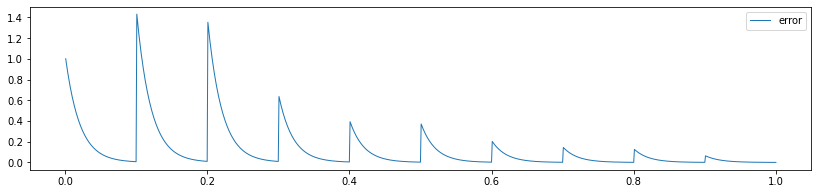

In [7]:
model = nengo.Network()
with model:
    model.config[nengo.Connection].synapse=None
    stim = nengo.Node(nengo.processes.PresentInput([p[0].v for p in pairs], presentation_time=t_present))
    target = nengo.Node(nengo.processes.PresentInput([p[1].v for p in pairs], presentation_time=t_present))
    output = nengo.Node(None, size_in=D)
    ens = nengo.Ensemble(n_neurons=N, dimensions=D, neuron_type=nengo.LIFRate(),
                        )
    nengo.Connection(stim, ens)
    
    learn = nengo.Node(Learner(size_in=ens.n_neurons, size_out=target.size_out,
                               tau_learn=0.02))
    error = nengo.Node(None, size_in=D)
    nengo.Connection(ens.neurons, learn[:ens.n_neurons])
    
    meta = nengo.Node(lambda t, x:1/(x+1)**2, size_in=N, size_out=N)
    nengo.Connection(ens.neurons, meta, synapse=0.1)
    nengo.Connection(meta, learn[ens.n_neurons:ens.n_neurons*2])
    
    nengo.Connection(learn, output)
    nengo.Connection(output, error)
    nengo.Connection(target, error, transform=-1)
    nengo.Connection(error, learn[-target.size_out:], synapse=0)
    
    p_error = nengo.Probe(error)

sim = nengo.Simulator(model)
with sim:
    sim.run(1)
    
plt.figure(figsize=(14,3))
plt.plot(sim.trange(), np.linalg.norm(sim.data[p_error], axis=1), lw=1, label='error')
plt.legend()
plt.show()

Better!  Now let's try  $1/(x+1)^3$.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

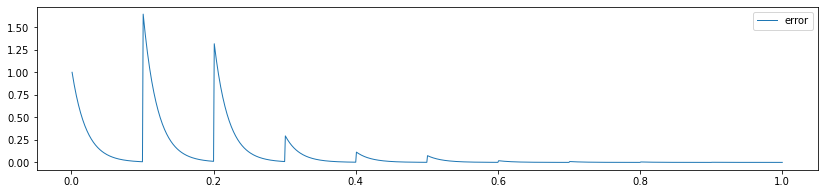

In [8]:
model = nengo.Network()
with model:
    model.config[nengo.Connection].synapse=None
    stim = nengo.Node(nengo.processes.PresentInput([p[0].v for p in pairs], presentation_time=t_present))
    target = nengo.Node(nengo.processes.PresentInput([p[1].v for p in pairs], presentation_time=t_present))
    output = nengo.Node(None, size_in=D)
    ens = nengo.Ensemble(n_neurons=N, dimensions=D, neuron_type=nengo.LIFRate(),
                        )
    nengo.Connection(stim, ens)
    
    learn = nengo.Node(Learner(size_in=ens.n_neurons, size_out=target.size_out,
                               tau_learn=0.02))
    error = nengo.Node(None, size_in=D)
    nengo.Connection(ens.neurons, learn[:ens.n_neurons])
    
    meta = nengo.Node(lambda t, x:1/(x+1)**3, size_in=N, size_out=N)
    nengo.Connection(ens.neurons, meta, synapse=0.1)
    nengo.Connection(meta, learn[ens.n_neurons:ens.n_neurons*2])
    
    nengo.Connection(learn, output)
    nengo.Connection(output, error)
    nengo.Connection(target, error, transform=-1)
    nengo.Connection(error, learn[-target.size_out:], synapse=0)
    
    p_error = nengo.Probe(error)

sim = nengo.Simulator(model)
with sim:
    sim.run(1)
    
plt.figure(figsize=(14,3))
plt.plot(sim.trange(), np.linalg.norm(sim.data[p_error], axis=1), lw=1, label='error')
plt.legend()
plt.show()

Success!  We can now learn without catastrophic forgetting with a non-sparse set of neurons!  We just scale each neuron's learning rate by $(a_i(t) \ast h(t))^{-p}$ where $h(t)$ is a long-time-constant low-pass filter and $p$ is the amount we want to emphasize the neurons that haven't spiked much (note that if $p=0$ then this is normal delta rule).

But, of course, this is just one option for computing the meta scaling factor.  As another option, we could scale by the derivative of the neural activity.  In this case, newly spiking neurons would be accentuated more.  

In the implementation below, we use the normal nengo trick of approximating a derivative by subtracting two low-pass filters with different time constants (which actually computes a smoothed version of the derivative, which is probably what we want here).

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

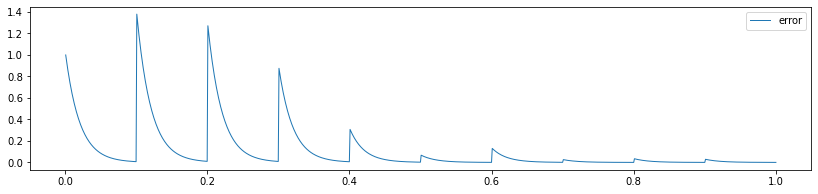

In [9]:
model = nengo.Network()
with model:
    model.config[nengo.Connection].synapse=None
    stim = nengo.Node(nengo.processes.PresentInput([p[0].v for p in pairs], presentation_time=t_present))
    target = nengo.Node(nengo.processes.PresentInput([p[1].v for p in pairs], presentation_time=t_present))
    output = nengo.Node(None, size_in=D)
    ens = nengo.Ensemble(n_neurons=N, dimensions=D, neuron_type=nengo.LIFRate(),
                        )
    nengo.Connection(stim, ens)
    
    learn = nengo.Node(Learner(size_in=ens.n_neurons, size_out=target.size_out,
                               tau_learn=0.02))
    error = nengo.Node(None, size_in=D)
    nengo.Connection(ens.neurons, learn[:ens.n_neurons])
    
    importance = nengo.Node(None, size_in=N)
    nengo.Connection(ens.neurons, importance, synapse=0.002)
    nengo.Connection(ens.neurons, importance, synapse=0.02, transform=-1)
    nengo.Connection(importance, learn[ens.n_neurons:ens.n_neurons*2])
    
    nengo.Connection(learn, output)
    nengo.Connection(output, error)
    nengo.Connection(target, error, transform=-1)
    nengo.Connection(error, learn[-target.size_out:], synapse=0)
    
    p_error = nengo.Probe(error)

sim = nengo.Simulator(model)
with sim:
    sim.run(1)
    
plt.figure(figsize=(14,3))
plt.plot(sim.trange(), np.linalg.norm(sim.data[p_error], axis=1), lw=1, label='error')
plt.legend()
plt.show()

This also seems to work well!

Any other ideas?